In [1]:
import pandas as pd
import numpy as np
import json
import ast # Used sometimes if json.loads fails unexpectedly

# --- PHASE 1: Loading, Merging, and Initial Cleaning ---

# Merging the TMDB 5000 Movie Dataset and TMDB 5000 Credits Dataset
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')

# 1. Merge the two DataFrames on 'id' (from movies_df) and 'movie_id' (from credits_df)
merged_df = pd.merge(movies_df, credits_df, left_on='id', right_on='movie_id', how='inner')

# 2. Drop redundant and unnecessary columns
merged_df.drop('movie_id', axis=1, inplace=True) # Redundant ID column
merged_df.drop('title_y', axis=1, inplace=True) # Redundant title from credits file
merged_df.drop('original_title', axis=1, inplace=True) # Keeping only English 'title'

# 3. Rename columns for clarity
merged_df = merged_df.rename(columns={'title_x': 'title'})

# 4. Critical: Ensure 'id' remains a column, NOT an index.
if merged_df.index.name == 'id':
    merged_df.reset_index(inplace=True)

# 5. Handle simple missing values
merged_df['tagline'] = merged_df['tagline'].fillna('')
merged_df['overview'] = merged_df['overview'].fillna('')
merged_df['homepage'] = merged_df['homepage'].fillna('')

# 6. Handle release_date and runtime
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'], errors='coerce')
# Drop rows where release_date failed (1 missing row in original data)
merged_df.dropna(subset=['release_date'], inplace=True)

# Fill missing runtime with the median value
merged_df['runtime'] = merged_df['runtime'].fillna(merged_df['runtime'].median())

print("Initial Merging and Cleaning complete.")
print(f"Current TMDB ID column type: {merged_df['id'].dtype}")

# --- PHASE 2: JSON Parsing and Flattening ---

# Define a safe parser function for JSON columns (using ast.literal_eval as a fallback for safety)
def safe_json_parse(json_string):
    try:
        # Tries standard JSON load
        return json.loads(json_string)
    except:
        # Fallback for poorly formatted strings
        try:
            return ast.literal_eval(json_string)
        except:
            return []

# Helper function to extract and join names from JSON list
def extract_names(json_list):
    return ', '.join([item['name'] for item in json_list])

# --- Apply Parsers ---

# 1. Genres
merged_df['genres'] = merged_df['genres'].apply(safe_json_parse).apply(extract_names)

# 2. Keywords
merged_df['keywords'] = merged_df['keywords'].apply(safe_json_parse).apply(extract_names)

# 3. Production Companies
merged_df['production_companies'] = merged_df['production_companies'].apply(safe_json_parse).apply(extract_names)

# 4. Spoken Languages
merged_df['spoken_languages'] = merged_df['spoken_languages'].apply(safe_json_parse).apply(extract_names)

# 5. Production Countries
merged_df['production_countries'] = merged_df['production_countries'].apply(safe_json_parse).apply(extract_names)

# 6. Cast (Top 6 actors/actresses)
def parse_cast_top_n(x, n=6):
    cast = safe_json_parse(x)
    return ', '.join([actor['name'] for actor in cast[:n]])
merged_df['cast'] = merged_df['cast'].apply(parse_cast_top_n)

# 7. Crew (All crew members with job description)
def parse_crew_full(x):
    crew = safe_json_parse(x)
    return ', '.join([f"{member['name']} ({member['job']})" for member in crew])
merged_df['crew'] = merged_df['crew'].apply(parse_crew_full)

# --- PHASE 3: Final Save ---

output_filename = 'clean_parsed_tmdb_5000.csv'

# FINAL CHECK: Ensure 'id' is included in the saved file.
merged_df.to_csv(output_filename, index=False)

print(f"\nSuccessfully created Clean TMDB Data.")
print(f"Saved to: {output_filename}")
print(f"Final DataFrame shape: {merged_df.shape}")
print(f"The 'id' column is successfully preserved as a column.")

Initial Merging and Cleaning complete.
Current TMDB ID column type: int64

Successfully created Clean TMDB Data.
Saved to: clean_parsed_tmdb_5000.csv
Final DataFrame shape: (4802, 21)
The 'id' column is successfully preserved as a column.


In [2]:
import pandas as pd
import numpy as np
import os
from google.colab import files # Used for displaying the files sidebar upload utility (optional, but helpful for context)

# --- Step 1: Load Data ---
LINKS_FILE = 'links.csv'
RATINGS_FILE = 'ratings.csv'
OUTPUT_FILE = 'ml_ratings_with_tmdb_id.csv'

try:
    # Read files directly from the current Colab directory
    links_df = pd.read_csv(LINKS_FILE)
    ratings_df = pd.read_csv(RATINGS_FILE)
    print("MovieLens datasets loaded successfully from the Colab environment.")
except FileNotFoundError:
    print(f"Error: Could not find one or both files ({LINKS_FILE}, {RATINGS_FILE}).")
    print("Please ensure the files are uploaded to the root directory of your Colab session.")
    # Exit execution if files are missing
    exit()

# --- Step 2: Clean and Prepare Links Data ---
# links.csv contains movieId, imdbId, tmdbId.
# We need 'movieId' to link with ratings and 'tmdbId' to link with the TMDB 5000 dataset.

# Drop rows where tmdbId is missing, as we need this ID for joining with TMDB 5000.
links_df.dropna(subset=['tmdbId'], inplace=True)

# Convert tmdbId to integer type (it's often stored as float due to NaNs)
links_df['tmdbId'] = links_df['tmdbId'].astype(int)

# Select only the necessary columns
links_cleaned = links_df[['movieId', 'tmdbId']]
print(f"Links data cleaned. Retained {links_cleaned.shape[0]} records with valid TMDB IDs.")

# --- Step 3: Clean and Prepare Ratings Data ---
# ratings.csv contains userId, movieId, rating, timestamp.
# For collaborative filtering, we primarily need userId, movieId, and rating.
ratings_cleaned = ratings_df[['userId', 'movieId', 'rating']]
print(f"Ratings data cleaned. Retained {ratings_cleaned.shape[0]} rating records.")

# --- Step 4: Merge DataFrames ---
# Merge the ratings data with the TMDB ID based on the common 'movieId'.
# An inner merge ensures we only keep ratings for movies that have a valid tmdbId in the links file.
merged_ratings_tmdb = pd.merge(
    ratings_cleaned,
    links_cleaned,
    on='movieId',
    how='inner'
)

# Rename the tmdbId column to 'id' to match the column name in the 'clean_parsed_tmdb_5000.csv'
merged_ratings_tmdb.rename(columns={'tmdbId': 'id'}, inplace=True)

print("\nMovieLens Ratings successfully merged with TMDB ID.")
print(f"Final merged dataset shape: {merged_ratings_tmdb.shape}")
print("First 5 rows of the merged data:")
print(merged_ratings_tmdb.head())

# --- Step 5: Save the Result ---
# Save the new DataFrame containing userId, movieId, rating, and the TMDB 'id'.
merged_ratings_tmdb.to_csv(OUTPUT_FILE, index=False)
print(f"\nSuccessfully saved the final ratings-to-TMDB-ID mapping file to: {OUTPUT_FILE}")
print("This file can now be used for collaborative filtering or merged with your TMDB 5000 movie features.")

MovieLens datasets loaded successfully from the Colab environment.
Links data cleaned. Retained 9734 records with valid TMDB IDs.
Ratings data cleaned. Retained 100836 rating records.

MovieLens Ratings successfully merged with TMDB ID.
Final merged dataset shape: (100823, 4)
First 5 rows of the merged data:
   userId  movieId  rating     id
0       1        1     4.0    862
1       1        3     4.0  15602
2       1        6     4.0    949
3       1       47     5.0    807
4       1       50     5.0    629

Successfully saved the final ratings-to-TMDB-ID mapping file to: ml_ratings_with_tmdb_id.csv
This file can now be used for collaborative filtering or merged with your TMDB 5000 movie features.


Data loaded successfully.
Filtered records (only movies in TMDB 5000): 70194.
Total Users: 610, Total Items: 3535

--- Starting Hybrid Model Training ---
Epoch 1/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - RMSE: 0.9319 - loss: 1.0915 - mae: 0.7226 - val_RMSE: 0.8773 - val_loss: 0.8822 - val_mae: 0.6697 - learning_rate: 0.0010
Epoch 2/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - RMSE: 0.8679 - loss: 0.8641 - mae: 0.6693 - val_RMSE: 0.8671 - val_loss: 0.8661 - val_mae: 0.6612 - learning_rate: 0.0010
Epoch 3/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - RMSE: 0.8548 - loss: 0.8402 - mae: 0.6586 - val_RMSE: 0.8606 - val_loss: 0.8518 - val_mae: 0.6569 - learning_rate: 0.0010
Epoch 4/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - RMSE: 0.8442 - loss: 0.8177 - mae: 0.6500 - val_RMSE: 0.8565 - val_loss: 0.8420 - val_mae: 0.6531 - learning_rate: 0.0010
Epoch 5/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - RMSE: 0.8345 - loss: 0.8008 - mae: 0.6423 - val_RMSE: 0.8546 - val_loss: 0.8417 - 

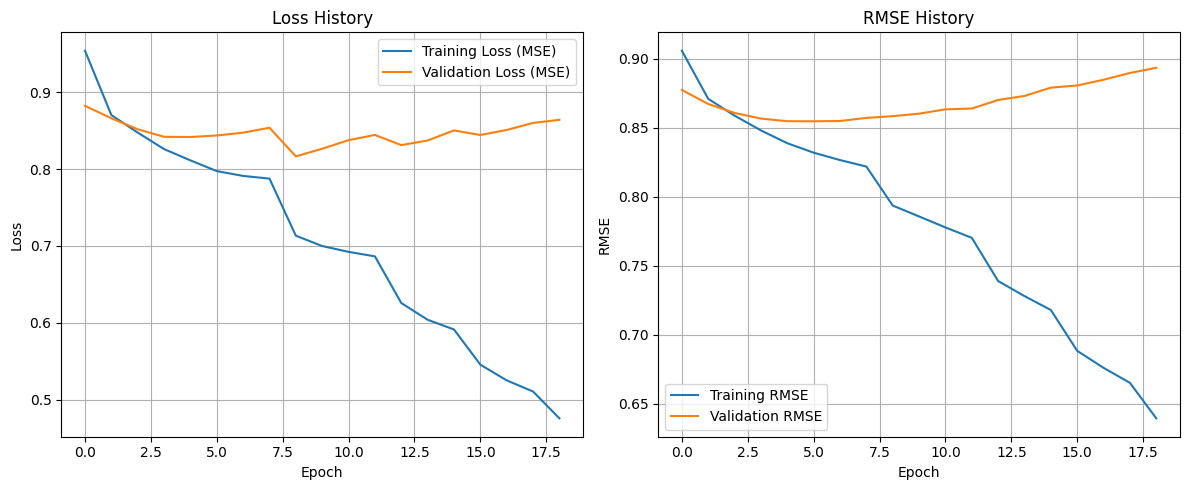


--- Top 10 Ranked Predictions for User ID 249 (Qualitative Review) ---
                          title  tmdb_id  predicted_rating  \
0                    Inside Job    44639          4.618436   
1               The Celebration      309          4.551102   
2                         Glory     9665          4.543627   
3            Lawrence of Arabia      947          4.529270   
4              Eastern Promises     2252          4.510344   
5      A Streetcar Named Desire      702          4.492651   
6  The Bridge on the River Kwai      826          4.477501   
7                        Patton    11202          4.473084   
8                   Hoop Dreams    14275          4.472578   
9                   The Hustler      990          4.455482   

                           genres  
0                     Documentary  
1                           Drama  
2                             War  
3  Adventure, Drama, History, War  
4        Thriller, Crime, Mystery  
5                           D

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Add, Lambda, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

RATINGS_FILE = 'ml_ratings_with_tmdb_id.csv'
TMDB_METADATA_FILE = 'clean_parsed_tmdb_5000.csv'
LATENT_DIM = 100
EPOCHS = 50
BATCH_SIZE = 64
SEED = 42
REG_L2 = 0.005
MIN_RATING = 0.5
MAX_RATING = 5.0
PATIENCE = 10

tf.random.set_seed(SEED)
np.random.seed(SEED)

try:
    ratings_df = pd.read_csv(RATINGS_FILE)
    ratings = ratings_df.rename(columns={'id': 'itemId'})[['userId', 'itemId', 'rating']]
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {RATINGS_FILE} not found. Exiting.")
    exit()

try:
    tmdb_metadata = pd.read_csv(TMDB_METADATA_FILE)
    valid_tmdb_ids = tmdb_metadata['id'].unique()
    ratings = ratings[ratings['itemId'].isin(valid_tmdb_ids)].copy()
    print(f"Filtered records (only movies in TMDB 5000): {ratings.shape[0]}.")
except FileNotFoundError:
    print(f"Warning: Metadata file {TMDB_METADATA_FILE} not found. Proceeding with unfiltered data.")

user_ids = ratings['userId'].astype('category').cat.codes
movie_ids = ratings['itemId'].astype('category').cat.codes

user_map = dict(enumerate(ratings['userId'].astype('category').cat.categories))
movie_map = dict(enumerate(ratings['itemId'].astype('category').cat.categories))

num_users = len(user_ids.unique())
num_movies = len(movie_ids.unique())
global_mean = ratings['rating'].mean()

X = pd.DataFrame({'user_id': user_ids, 'movie_id': movie_ids})
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(f"Total Users: {num_users}, Total Items: {num_movies}")

def build_ncf_optimized_model(num_users, num_movies, latent_dim, reg_l2, global_mean, min_rating, max_rating):

    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=latent_dim, embeddings_regularizer=l2(reg_l2), name='user_factors')(user_input)
    user_vec = Flatten(name='flatten_user')(user_embedding)

    movie_embedding = Embedding(input_dim=num_movies, output_dim=latent_dim, embeddings_regularizer=l2(reg_l2), name='movie_factors')(movie_input)
    movie_vec = Flatten(name='flatten_movie')(movie_embedding)

    concatenated = Concatenate(name='concat_vectors')([user_vec, movie_vec])

    dense_1 = Dense(latent_dim * 2, activation='relu', name='dense_1')(concatenated)
    dense_2 = Dense(latent_dim, activation='relu', name='dense_2')(dense_1)

    nmf_output = Dense(1, name='nmf_output_layer')(dense_2)

    user_bias = Embedding(input_dim=num_users, output_dim=1, embeddings_regularizer=l2(reg_l2), name='user_bias')(user_input)
    user_bias_flat = Flatten(name='flatten_user_bias')(user_bias)

    movie_bias = Embedding(input_dim=num_movies, output_dim=1, embeddings_regularizer=l2(reg_l2), name='movie_bias')(movie_input)
    movie_bias_flat = Flatten(name='flatten_movie_bias')(movie_bias)


    raw_output = Add(name='predicted_rating_raw')([nmf_output, user_bias_flat, movie_bias_flat])
    global_mean_add = Lambda(lambda x: x + global_mean, name='global_mean_add')(raw_output)

    final_output = Lambda(lambda x: tf.clip_by_value(x, min_rating, max_rating), name='final_clipping')(global_mean_add)

    model = Model(inputs=[user_input, movie_input], outputs=final_output)

    model.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE'), 'mae'])

    return model

model_ncf_style = build_ncf_optimized_model(num_users, num_movies, LATENT_DIM, REG_L2, global_mean, MIN_RATING, MAX_RATING)
model_svd = model_ncf_style

print("\n--- Starting Hybrid Model Training ---")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.00001)
]

history = model_svd.fit(
    [X_train['user_id'], X_train['movie_id']],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=([X_test['user_id'], X_test['movie_id']], y_test),
    callbacks=callbacks
)

print("\n--- Training Complete ---")

metrics = model_svd.evaluate([X_test['user_id'], X_test['movie_id']], y_test, verbose=0)
rmse = metrics[1]
mae = metrics[2]

print("\n--- Final Model Performance (Prediction Accuracy) ---")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")


def plot_training_history(history):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    if 'RMSE' in history.history and 'val_RMSE' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['RMSE'], label='Training RMSE')
        plt.plot(history.history['val_RMSE'], label='Validation RMSE')
        plt.title('RMSE History')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

plot_training_history(history)


RELEVANCE_THRESHOLD = 3.0
K = 10

def get_top_n_predictions(user_id, model, user_map, movie_map, ratings_df, n=10):
    try:
        user_map_reverse = {v: k for k, v in user_map.items()}
        encoded_user = user_map_reverse[user_id]
    except KeyError:
        return pd.DataFrame()

    movie_df = pd.DataFrame(list(movie_map.items()), columns=['encoded_movie_id', 'tmdb_id'])
    rated_tmdb_ids = ratings_df[ratings_df['userId'] == user_id]['itemId'].tolist()

    unrated_movies_df = movie_df[~movie_df['tmdb_id'].isin(rated_tmdb_ids)].reset_index(drop=True)

    predicted_ratings_array = model.predict([np.array([encoded_user] * len(unrated_movies_df)), unrated_movies_df['encoded_movie_id'].values], verbose=0).flatten()

    unrated_movies_df['predicted_rating'] = predicted_ratings_array

    top_predictions = unrated_movies_df.sort_values(
        by='predicted_rating', ascending=False
    ).head(n)

    return top_predictions[['tmdb_id', 'predicted_rating', 'encoded_movie_id']]


user_test_movies = X_test.copy()
user_test_movies['actual_rating'] = y_test
user_test_movies = user_test_movies[user_test_movies['actual_rating'] >= RELEVANCE_THRESHOLD]

relevant_items_per_user = defaultdict(set)
for user_id, movie_id in zip(user_test_movies['user_id'], user_test_movies['movie_id']):
    relevant_items_per_user[user_id].add(movie_id)

test_users = [user for user, items in relevant_items_per_user.items() if items]

precisions = []
recalls = []
aps = []
total_TP = 0
total_FP = 0
total_FN = 0
all_encoded_movies = np.arange(num_movies)

for i, encoded_user in enumerate(test_users):

    user_input = np.array([encoded_user] * num_movies)
    movie_input = all_encoded_movies

    predicted_ratings = model_svd.predict([user_input, movie_input], verbose=0).flatten()

    predictions_df = pd.DataFrame({'encoded_movie_id': all_encoded_movies, 'predicted_rating': predicted_ratings})

    rated_in_train = set(X_train[X_train['user_id'] == encoded_user]['movie_id'])
    recommendations_df = predictions_df[~predictions_df['encoded_movie_id'].isin(rated_in_train)]

    top_k_recommendations = recommendations_df.sort_values(
        by='predicted_rating', ascending=False
    ).head(K)['encoded_movie_id'].tolist()

    relevant_set = relevant_items_per_user[encoded_user]

    true_positives = len(relevant_set.intersection(set(top_k_recommendations)))

    precision_k = true_positives / K if K > 0 else 0
    precisions.append(precision_k)

    total_relevant = len(relevant_set)
    recall_k = true_positives / total_relevant if total_relevant > 0 else 0
    recalls.append(recall_k)

    ap = 0.0
    hits = 0
    for j, movie in enumerate(top_k_recommendations):
        if movie in relevant_set:
            hits += 1
            ap += hits / (j + 1)

    ap = ap / min(total_relevant, K) if min(total_relevant, K) > 0 else 0
    aps.append(ap)

    total_TP += true_positives
    total_FP += (K - true_positives)
    total_FN += (total_relevant - true_positives)

mean_precision_k = np.mean(precisions)
mean_recall_k = np.mean(recalls)
mean_average_precision = np.mean(aps)

if mean_precision_k + mean_recall_k > 0:
    mean_f1_k = 2 * (mean_precision_k * mean_recall_k) / (mean_precision_k + mean_recall_k)
else:
    mean_f1_k = 0.0


RECOMMENDATION_USER_ID = 249
TOP_N = 10

final_predictions_df = get_top_n_predictions(
    RECOMMENDATION_USER_ID, model_svd, user_map, movie_map, ratings, TOP_N
)

print(f"\n--- Top {TOP_N} Ranked Predictions for User ID {RECOMMENDATION_USER_ID} (Qualitative Review) ---")

try:
    df_tmdb_metadata = pd.read_csv(TMDB_METADATA_FILE)
    df_tmdb_metadata = df_tmdb_metadata.rename(columns={'id': 'tmdb_id'})

    predictions_with_titles = pd.merge(
        final_predictions_df.drop(columns=['encoded_movie_id']),
        df_tmdb_metadata[['tmdb_id', 'title', 'genres']],
        on='tmdb_id',
        how='left'
    )

    print(predictions_with_titles[['title', 'tmdb_id', 'predicted_rating', 'genres']])

except FileNotFoundError:
    print(f"Could not load '{TMDB_METADATA_FILE}' to retrieve movie titles.")
    print("Raw TMDB IDs and Predicted Ratings:")
    print(final_predictions_df)